Direct damages calculation for CI Adapt

In [1]:
import configparser
from pathlib import Path
import pathlib
from direct_damages import damagescanner_rail_track as ds
import pandas as pd
import datetime
from ci_adapt_utilities import *
import pickle
import os
from matplotlib import pyplot as plt

Load default configuration and parameters

In [2]:
# Load configuration with ini file (created running config.py)
config_file=r'C:\repos\ci_adapt\config_ci_adapt.ini'
config = configparser.ConfigParser()
config.read(config_file)

p = Path('..')
hazard_type = config.get('DEFAULT', 'hazard_type')
infra_type = config.get('DEFAULT', 'infra_type')
country_code = config.get('DEFAULT', 'country_code')
country_name = config.get('DEFAULT', 'country_name')
hazard_data_subfolders = config.get('DEFAULT', 'hazard_data_subfolders')
asset_data = config.get('DEFAULT', 'asset_data')
vulnerability_data = config.get('DEFAULT', 'vulnerability_data')
data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'

Read risk data (asset exposure, vulnerability, hazard)

In [3]:
# Read exposure data (OSM, OpenStreetMap contributors (2024) / osm-flex)
assets_path = data_path / asset_data
assets = preprocess_assets(assets_path)
asset_options={'bridge_design_rp':'M',
               'tunnel_design_rp':'M'}

# Add buffer to assets to do area intersect and create dictionaries for quicker lookup
buffered_assets = ds.buffer_assets(assets)
geom_dict = assets['geometry'].to_dict()
type_dict = assets['asset'].to_dict()

print(f"{len(assets)} assets loaded.")

47210 assets loaded.


In [4]:
# Read vulnerability and maximum damage data from Nirandjan, S., et al. (2024)
curve_types = {'rail': ['F8.1']}
infra_curves, maxdams = ds.read_vul_maxdam(data_path, hazard_type, infra_type)
max_damage_tables = pd.read_excel(data_path / vulnerability_data / 'Table_D3_Costs_V1.0.0.xlsx',sheet_name='Cost_Database',index_col=[0])
print(f'Found matching infrastructure curves for: {infra_type}')

Found matching infrastructure curves for: rail


In [5]:
# Read hazard data (Rauthe M, et al. (2020): Climate impact analysis of the federal transport system in the context of floods: Final report of the key topic flood risks (SP-103) in topic area 1 of the BMVI expert network. 136 pages. DOI: 10.5675/ExpNRM2020.2020.04)
n_drive_dpath=Path(r'N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps')
# local_haz_path=data_path/r'Floods\Germany\fluvial_undefended\raw_subsample\validated_geometries'
hazard_data_list = ds.read_hazard_data(n_drive_dpath, hazard_type, country=country_name, subfolders=None)
print(f'Found {len(hazard_data_list)} hazard maps.')

Found 183 hazard maps.


In [6]:
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
rp_spec_priority = set_rp_priorities(return_period_dict)

Overlay hazard and asset data

In [7]:
# Calculate direct damage by asset (Koks. E.E. (2022). DamageScanner: Python tool for natural hazard damage assessments. Zenodo. http://doi.org/10.5281/zenodo.2551015)
collect_output={}
for i, single_footprint in enumerate(hazard_data_list):
    hazard_name = single_footprint.parts[-1].split('.')[0]
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    print(f'{timestamp} - Reading hazard map {i+1} of {len(hazard_data_list)}: {hazard_name}')

    try:
        collect_output[hazard_name] = process_hazard_data(single_footprint, hazard_type, assets, interim_data_path, infra_curves, max_damage_tables, curve_types, infra_type, type_dict, geom_dict, asset_options=asset_options, rp_spec_priority=rp_spec_priority)
    except Exception as e:
        print(f'Error occurred in {hazard_name}: {str(e)}')
        continue

# save the data to pickle files
collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
if len(collect_output)>0:
    with open(collect_output_path, 'wb') as f:
        pickle.dump(collect_output, f)
else: print('No output collected')

2024-10-08 17:03:37 - Reading hazard map 1 of 183: flood_DERP_RW_H_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410170.geojson
2024-10-08 17:03:43 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [00:01<00:00, 24.06it/s]


2024-10-08 17:05:18 - Reading hazard map 2 of 183: flood_DERP_RW_H_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410430.geojson
2024-10-08 17:05:21 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:02<00:00,  5.17it/s]


2024-10-08 17:06:16 - Reading hazard map 3 of 183: flood_DERP_RW_H_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410540.geojson
2024-10-08 17:06:22 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:00<00:00, 20.43it/s]


2024-10-08 17:08:33 - Reading hazard map 4 of 183: flood_DERP_RW_H_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410660.geojson
2024-10-08 17:08:35 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:00<00:00, 3329.87it/s]


2024-10-08 17:08:40 - Reading hazard map 5 of 183: flood_DERP_RW_H_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080410760.geojson
2024-10-08 17:08:50 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 2995.93it/s]


2024-10-08 17:10:04 - Reading hazard map 6 of 183: flood_DERP_RW_H_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080411370.geojson
2024-10-08 17:10:08 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:05<00:00,  3.29it/s]


2024-10-08 17:11:41 - Reading hazard map 7 of 183: flood_DERP_RW_H_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080416200.geojson
2024-10-08 17:11:58 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 1995.86it/s]


2024-10-08 17:16:23 - Reading hazard map 8 of 183: flood_DERP_RW_H_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080416210.geojson
2024-10-08 17:16:32 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [01:18<00:00,  3.91s/it]


2024-10-08 17:22:14 - Reading hazard map 9 of 183: flood_DERP_RW_H_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418600.geojson
2024-10-08 17:22:40 - Coarse overlay of hazard map with assets...


100%|██████████| 29/29 [01:44<00:00,  3.61s/it]


2024-10-08 17:40:36 - Reading hazard map 10 of 183: flood_DERP_RW_H_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418720.geojson
2024-10-08 17:40:37 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]

2024-10-08 17:40:37 - Reading hazard map 11 of 183: flood_DERP_RW_H_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418880.geojson


2024-10-08 17:40:44 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00,  7.19it/s]


2024-10-08 17:41:50 - Reading hazard map 12 of 183: flood_DERP_RW_H_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080418890.geojson
2024-10-08 17:42:00 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00, 2004.69it/s]


2024-10-08 17:42:10 - Reading hazard map 13 of 183: flood_DERP_RW_H_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080419070.geojson
2024-10-08 17:42:11 - Coarse overlay of hazard map with assets...


100%|██████████| 1/1 [00:00<00:00, 499.56it/s]


2024-10-08 17:42:11 - Reading hazard map 14 of 183: flood_DERP_RW_H_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080419180.geojson
2024-10-08 17:42:18 - Coarse overlay of hazard map with assets...


100%|██████████| 19/19 [00:23<00:00,  1.25s/it]


2024-10-08 17:43:41 - Reading hazard map 15 of 183: flood_DERP_RW_H_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080420240.geojson
2024-10-08 17:44:10 - Coarse overlay of hazard map with assets...


100%|██████████| 56/56 [09:30<00:00, 10.20s/it]


2024-10-08 18:25:29 - Reading hazard map 16 of 183: flood_DERP_RW_H_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080420340.geojson
2024-10-08 18:25:32 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00, 2500.48it/s]


2024-10-08 18:25:56 - Reading hazard map 17 of 183: flood_DERP_RW_H_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080421680.geojson
2024-10-08 18:26:16 - Coarse overlay of hazard map with assets...


100%|██████████| 40/40 [00:12<00:00,  3.11it/s]


2024-10-08 18:51:22 - Reading hazard map 18 of 183: flood_DERP_RW_H_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080421770.geojson
2024-10-08 18:51:34 - Coarse overlay of hazard map with assets...


100%|██████████| 18/18 [00:03<00:00,  4.92it/s]


2024-10-08 19:13:42 - Reading hazard map 19 of 183: flood_DERP_RW_H_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428080.geojson
2024-10-08 19:13:52 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 19:14:54 - Reading hazard map 20 of 183: flood_DERP_RW_H_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428160.geojson
2024-10-08 19:15:10 - Coarse overlay of hazard map with assets...


100%|██████████| 8/8 [02:30<00:00, 18.79s/it]


2024-10-08 19:22:27 - Reading hazard map 21 of 183: flood_DERP_RW_H_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080428500.geojson
2024-10-08 19:22:29 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 19:22:34 - Reading hazard map 22 of 183: flood_DERP_RW_H_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429430.geojson
2024-10-08 19:22:36 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:00<00:00, 21.91it/s]


2024-10-08 19:23:21 - Reading hazard map 23 of 183: flood_DERP_RW_H_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429540.geojson
2024-10-08 19:23:32 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:00<00:00,  6.74it/s]


2024-10-08 19:31:54 - Reading hazard map 24 of 183: flood_DERP_RW_H_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429670.geojson
2024-10-08 19:31:54 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]

2024-10-08 19:31:54 - Reading hazard map 25 of 183: flood_DERP_RW_H_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080429770.geojson


2024-10-08 19:31:54 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:00<00:00, 74.38it/s]


2024-10-08 19:31:54 - Reading hazard map 26 of 183: flood_DERP_RW_H_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080430240.geojson
2024-10-08 19:31:57 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


2024-10-08 19:33:01 - Reading hazard map 27 of 183: flood_DERP_RW_H_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080430320.geojson
2024-10-08 19:33:04 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:24<00:00,  1.24s/it]


2024-10-08 19:34:03 - Reading hazard map 28 of 183: flood_DERP_RW_H_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431110.geojson
2024-10-08 19:34:05 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 19:34:16 - Reading hazard map 29 of 183: flood_DERP_RW_H_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431660.geojson
2024-10-08 19:34:27 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 2003.97it/s]


2024-10-08 19:37:44 - Reading hazard map 30 of 183: flood_DERP_RW_H_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080431750.geojson
2024-10-08 19:37:56 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 19:38:54 - Reading hazard map 31 of 183: flood_DERP_RW_H_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080432400.geojson
2024-10-08 19:38:57 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00,  4.04it/s]


2024-10-08 19:39:17 - Reading hazard map 32 of 183: flood_DERP_RW_H_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080432510.geojson
2024-10-08 19:39:33 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:00<00:00, 18.47it/s]


2024-10-08 19:47:23 - Reading hazard map 33 of 183: flood_DERP_RW_H_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433520.geojson
2024-10-08 19:47:26 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 19:47:30 - Reading hazard map 34 of 183: flood_DERP_RW_H_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433740.geojson
2024-10-08 19:47:54 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 19:55:12 - Reading hazard map 35 of 183: flood_DERP_RW_H_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080433960.geojson
2024-10-08 19:55:44 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 20:00:15 - Reading hazard map 36 of 183: flood_DERP_RW_H_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434150.geojson
2024-10-08 20:00:19 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 20:00:24 - Reading hazard map 37 of 183: flood_DERP_RW_H_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434280.geojson
2024-10-08 20:00:28 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.84it/s]


2024-10-08 20:00:53 - Reading hazard map 38 of 183: flood_DERP_RW_H_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434470.geojson
2024-10-08 20:01:17 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [02:16<00:00,  4.03s/it] 


2024-10-08 20:13:19 - Reading hazard map 39 of 183: flood_DERP_RW_H_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434490.geojson
2024-10-08 20:13:26 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:00<00:00, 57.09it/s]


2024-10-08 20:15:24 - Reading hazard map 40 of 183: flood_DERP_RW_H_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080434630.geojson
2024-10-08 20:15:40 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 1490.69it/s]


2024-10-08 21:20:32 - Reading hazard map 41 of 183: flood_DERP_RW_H_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080435040.geojson
2024-10-08 21:21:07 - Coarse overlay of hazard map with assets...


100%|██████████| 58/58 [00:09<00:00,  6.12it/s]


2024-10-08 21:55:50 - Reading hazard map 42 of 183: flood_DERP_RW_H_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080435320.geojson
2024-10-08 21:56:00 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:07<00:00,  1.97s/it]


2024-10-08 21:58:13 - Reading hazard map 43 of 183: flood_DERP_RW_H_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436660.geojson
2024-10-08 21:58:17 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 21:58:24 - Reading hazard map 44 of 183: flood_DERP_RW_H_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436860.geojson
2024-10-08 21:58:24 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 21:58:25 - Reading hazard map 45 of 183: flood_DERP_RW_H_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080436870.geojson
2024-10-08 21:58:25 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 21:58:26 - Reading hazard map 46 of 183: flood_DERP_RW_H_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437100.geojson
2024-10-08 21:58:31 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:23<00:00,  7.87s/it]


2024-10-08 22:00:09 - Reading hazard map 47 of 183: flood_DERP_RW_H_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437230.geojson
2024-10-08 22:00:19 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:01<00:00,  2.89it/s]


2024-10-08 22:03:56 - Reading hazard map 48 of 183: flood_DERP_RW_H_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080437370.geojson
2024-10-08 22:04:00 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 1499.93it/s]


2024-10-08 22:04:44 - Reading hazard map 49 of 183: flood_DERP_RW_H_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438230.geojson
2024-10-08 22:04:51 - Coarse overlay of hazard map with assets...


100%|██████████| 5/5 [00:00<00:00, 2502.27it/s]


2024-10-08 22:07:56 - Reading hazard map 50 of 183: flood_DERP_RW_H_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438240.geojson
2024-10-08 22:08:01 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:05<00:00,  2.66it/s]


2024-10-08 22:08:49 - Reading hazard map 51 of 183: flood_DERP_RW_H_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438400.geojson
2024-10-08 22:09:10 - Coarse overlay of hazard map with assets...


100%|██████████| 21/21 [06:18<00:00, 18.04s/it]


2024-10-08 22:27:17 - Reading hazard map 52 of 183: flood_DERP_RW_H_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080438410.geojson
2024-10-08 22:27:25 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:03<00:00,  1.94it/s]


2024-10-08 22:30:49 - Reading hazard map 53 of 183: flood_DERP_RW_H_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080439400.geojson
2024-10-08 22:30:58 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 22:37:01 - Reading hazard map 54 of 183: flood_DERP_RW_H_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080439410.geojson
2024-10-08 22:37:06 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [00:03<00:00,  6.60it/s]


2024-10-08 22:39:37 - Reading hazard map 55 of 183: flood_DERP_RW_H_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080441280.geojson
2024-10-08 22:39:46 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:03<00:00,  3.66it/s]


2024-10-08 22:46:50 - Reading hazard map 56 of 183: flood_DERP_RW_H_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080446220.geojson
2024-10-08 22:46:59 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [01:17<00:00,  2.59s/it]


2024-10-08 22:51:08 - Reading hazard map 57 of 183: flood_DERP_RW_H_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080446320.geojson
2024-10-08 22:51:11 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-08 22:51:13 - Reading hazard map 58 of 183: flood_DERP_RW_H_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080447840.geojson
2024-10-08 22:52:01 - Coarse overlay of hazard map with assets...


100%|██████████| 54/54 [05:01<00:00,  5.57s/it]


2024-10-09 00:54:15 - Reading hazard map 59 of 183: flood_DERP_RW_H_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080447970.geojson
2024-10-09 00:54:24 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [02:25<00:00, 24.20s/it]


2024-10-09 00:59:40 - Reading hazard map 60 of 183: flood_DERP_RW_H_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080448120.geojson
2024-10-09 00:59:49 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 01:01:25 - Reading hazard map 61 of 183: flood_DERP_RW_H_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_H_4326_2080451930.geojson
2024-10-09 01:01:27 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00,  7.87it/s]


2024-10-09 01:01:29 - Reading hazard map 62 of 183: flood_DERP_RW_L_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410170.geojson
2024-10-09 01:01:37 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [01:51<00:00,  3.27s/it]


2024-10-09 01:09:36 - Reading hazard map 63 of 183: flood_DERP_RW_L_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410430.geojson
2024-10-09 01:09:41 - Coarse overlay of hazard map with assets...


100%|██████████| 20/20 [01:23<00:00,  4.17s/it]


2024-10-09 01:12:04 - Reading hazard map 64 of 183: flood_DERP_RW_L_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410540.geojson
2024-10-09 01:12:12 - Coarse overlay of hazard map with assets...


100%|██████████| 48/48 [08:22<00:00, 10.47s/it]


2024-10-09 01:24:00 - Reading hazard map 65 of 183: flood_DERP_RW_L_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410660.geojson
2024-10-09 01:24:03 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:07<00:00,  1.45it/s]


2024-10-09 01:24:19 - Reading hazard map 66 of 183: flood_DERP_RW_L_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080410760.geojson
2024-10-09 01:24:33 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [03:23<00:00, 67.85s/it]


2024-10-09 01:32:21 - Reading hazard map 67 of 183: flood_DERP_RW_L_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080411370.geojson
2024-10-09 01:32:25 - Coarse overlay of hazard map with assets...


100%|██████████| 100/100 [03:06<00:00,  1.87s/it]


2024-10-09 01:36:22 - Reading hazard map 68 of 183: flood_DERP_RW_L_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080416200.geojson
2024-10-09 01:36:44 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:07<00:00,  1.82s/it]


2024-10-09 01:43:03 - Reading hazard map 69 of 183: flood_DERP_RW_L_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080416210.geojson
2024-10-09 01:43:15 - Coarse overlay of hazard map with assets...


100%|██████████| 152/152 [08:54<00:00,  3.52s/it]


2024-10-09 01:55:24 - Reading hazard map 70 of 183: flood_DERP_RW_L_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418600.geojson
2024-10-09 01:55:54 - Coarse overlay of hazard map with assets...


100%|██████████| 67/67 [26:13<00:00, 23.48s/it]   


2024-10-09 02:45:53 - Reading hazard map 71 of 183: flood_DERP_RW_L_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418720.geojson
2024-10-09 02:45:53 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [00:00<00:00, 17.46it/s]


2024-10-09 02:45:54 - Reading hazard map 72 of 183: flood_DERP_RW_L_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418880.geojson
2024-10-09 02:46:05 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:07<00:00,  1.46it/s]


2024-10-09 02:48:32 - Reading hazard map 73 of 183: flood_DERP_RW_L_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080418890.geojson
2024-10-09 02:48:44 - Coarse overlay of hazard map with assets...


100%|██████████| 78/78 [03:43<00:00,  2.87s/it]


2024-10-09 02:55:13 - Reading hazard map 74 of 183: flood_DERP_RW_L_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080419070.geojson
2024-10-09 02:55:14 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00,  4.39it/s]


2024-10-09 02:55:17 - Reading hazard map 75 of 183: flood_DERP_RW_L_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080419180.geojson
2024-10-09 02:55:22 - Coarse overlay of hazard map with assets...


100%|██████████| 62/62 [01:21<00:00,  1.31s/it]


2024-10-09 02:58:15 - Reading hazard map 76 of 183: flood_DERP_RW_L_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080420240.geojson
2024-10-09 02:58:43 - Coarse overlay of hazard map with assets...


100%|██████████| 202/202 [1:22:33<00:00, 24.52s/it]  


2024-10-09 05:06:48 - Reading hazard map 77 of 183: flood_DERP_RW_L_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080420340.geojson
2024-10-09 05:06:51 - Coarse overlay of hazard map with assets...


100%|██████████| 32/32 [00:23<00:00,  1.37it/s]


2024-10-09 05:07:47 - Reading hazard map 78 of 183: flood_DERP_RW_L_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080421680.geojson
2024-10-09 05:08:11 - Coarse overlay of hazard map with assets...


100%|██████████| 119/119 [58:59<00:00, 29.74s/it] 


2024-10-09 06:57:17 - Reading hazard map 79 of 183: flood_DERP_RW_L_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080421770.geojson
2024-10-09 06:57:29 - Coarse overlay of hazard map with assets...


100%|██████████| 190/190 [1:10:59<00:00, 22.42s/it] 


2024-10-09 08:22:02 - Reading hazard map 80 of 183: flood_DERP_RW_L_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428080.geojson
2024-10-09 08:22:16 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 08:23:41 - Reading hazard map 81 of 183: flood_DERP_RW_L_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428160.geojson
2024-10-09 08:23:55 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [00:51<00:00,  4.65s/it]


2024-10-09 08:30:40 - Reading hazard map 82 of 183: flood_DERP_RW_L_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080428500.geojson
2024-10-09 08:30:42 - Coarse overlay of hazard map with assets...


100%|██████████| 28/28 [00:09<00:00,  2.92it/s]


2024-10-09 08:31:03 - Reading hazard map 83 of 183: flood_DERP_RW_L_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429430.geojson
2024-10-09 08:31:08 - Coarse overlay of hazard map with assets...


100%|██████████| 112/112 [08:05<00:00,  4.33s/it]


2024-10-09 08:43:32 - Reading hazard map 84 of 183: flood_DERP_RW_L_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429540.geojson
2024-10-09 08:43:50 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:04<00:00,  1.32it/s]


2024-10-09 08:48:39 - Reading hazard map 85 of 183: flood_DERP_RW_L_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429670.geojson
2024-10-09 08:48:40 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 08:48:40 - Reading hazard map 86 of 183: flood_DERP_RW_L_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080429770.geojson
2024-10-09 08:48:40 - Coarse overlay of hazard map with assets...


100%|██████████| 56/56 [00:08<00:00,  6.73it/s]


2024-10-09 08:48:50 - Reading hazard map 87 of 183: flood_DERP_RW_L_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080430240.geojson
2024-10-09 08:48:54 - Coarse overlay of hazard map with assets...


100%|██████████| 25/25 [00:42<00:00,  1.71s/it]


2024-10-09 08:50:33 - Reading hazard map 88 of 183: flood_DERP_RW_L_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080430320.geojson
2024-10-09 08:50:40 - Coarse overlay of hazard map with assets...


100%|██████████| 42/42 [02:25<00:00,  3.46s/it]


2024-10-09 08:53:46 - Reading hazard map 89 of 183: flood_DERP_RW_L_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431110.geojson
2024-10-09 08:53:50 - Coarse overlay of hazard map with assets...


100%|██████████| 88/88 [02:19<00:00,  1.58s/it]


2024-10-09 08:57:54 - Reading hazard map 90 of 183: flood_DERP_RW_L_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431660.geojson
2024-10-09 08:58:08 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:05<00:00,  2.66s/it]


2024-10-09 09:05:26 - Reading hazard map 91 of 183: flood_DERP_RW_L_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080431750.geojson
2024-10-09 09:05:40 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 09:07:05 - Reading hazard map 92 of 183: flood_DERP_RW_L_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080432400.geojson
2024-10-09 09:07:10 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:03<00:00,  1.22it/s]


2024-10-09 09:07:33 - Reading hazard map 93 of 183: flood_DERP_RW_L_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080432510.geojson
2024-10-09 09:08:05 - Coarse overlay of hazard map with assets...


100%|██████████| 54/54 [15:33<00:00, 17.28s/it]   


2024-10-09 09:46:37 - Reading hazard map 94 of 183: flood_DERP_RW_L_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433520.geojson
2024-10-09 09:46:40 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 09:46:44 - Reading hazard map 95 of 183: flood_DERP_RW_L_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433740.geojson
2024-10-09 09:47:05 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 09:51:39 - Reading hazard map 96 of 183: flood_DERP_RW_L_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080433960.geojson
2024-10-09 09:52:30 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 09:58:22 - Reading hazard map 97 of 183: flood_DERP_RW_L_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434150.geojson
2024-10-09 09:58:26 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 09:58:30 - Reading hazard map 98 of 183: flood_DERP_RW_L_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434280.geojson
2024-10-09 09:58:36 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [01:04<00:00,  6.50s/it]


2024-10-09 10:00:25 - Reading hazard map 99 of 183: flood_DERP_RW_L_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434470.geojson
2024-10-09 10:01:06 - Coarse overlay of hazard map with assets...


100%|██████████| 170/170 [1:09:28<00:00, 24.52s/it]


2024-10-09 11:30:50 - Reading hazard map 100 of 183: flood_DERP_RW_L_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434490.geojson
2024-10-09 11:31:02 - Coarse overlay of hazard map with assets...


100%|██████████| 44/44 [07:16<00:00,  9.93s/it]


2024-10-09 11:43:43 - Reading hazard map 101 of 183: flood_DERP_RW_L_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080434630.geojson
2024-10-09 11:44:39 - Coarse overlay of hazard map with assets...


100%|██████████| 140/140 [3:20:36<00:00, 85.97s/it]   


2024-10-09 17:31:50 - Reading hazard map 102 of 183: flood_DERP_RW_L_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080435040.geojson
2024-10-09 17:32:35 - Coarse overlay of hazard map with assets...


100%|██████████| 100/100 [39:19<00:00, 23.59s/it]  


2024-10-09 18:53:03 - Reading hazard map 103 of 183: flood_DERP_RW_L_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080435320.geojson
2024-10-09 18:53:14 - Coarse overlay of hazard map with assets...


100%|██████████| 12/12 [02:19<00:00, 11.60s/it]


2024-10-09 18:56:51 - Reading hazard map 104 of 183: flood_DERP_RW_L_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436660.geojson
2024-10-09 18:56:55 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-09 18:57:03 - Reading hazard map 105 of 183: flood_DERP_RW_L_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436860.geojson
2024-10-09 18:57:03 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00,  5.38it/s]


2024-10-09 18:57:05 - Reading hazard map 106 of 183: flood_DERP_RW_L_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080436870.geojson
2024-10-09 18:57:08 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [00:28<00:00,  1.21it/s]


2024-10-09 18:57:51 - Reading hazard map 107 of 183: flood_DERP_RW_L_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437100.geojson
2024-10-09 18:58:00 - Coarse overlay of hazard map with assets...


100%|██████████| 31/31 [07:19<00:00, 14.17s/it]


2024-10-09 19:08:51 - Reading hazard map 108 of 183: flood_DERP_RW_L_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437230.geojson
2024-10-09 19:08:56 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:01<00:00,  1.23it/s]


2024-10-09 19:09:35 - Reading hazard map 109 of 183: flood_DERP_RW_L_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080437370.geojson
2024-10-09 19:09:40 - Coarse overlay of hazard map with assets...


100%|██████████| 67/67 [04:44<00:00,  4.25s/it]


2024-10-09 19:15:22 - Reading hazard map 110 of 183: flood_DERP_RW_L_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438230.geojson
2024-10-09 19:15:35 - Coarse overlay of hazard map with assets...


100%|██████████| 25/25 [00:19<00:00,  1.29it/s]


2024-10-09 19:24:08 - Reading hazard map 111 of 183: flood_DERP_RW_L_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438240.geojson
2024-10-09 19:24:15 - Coarse overlay of hazard map with assets...


100%|██████████| 81/81 [00:50<00:00,  1.61it/s]


2024-10-09 19:26:20 - Reading hazard map 112 of 183: flood_DERP_RW_L_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438400.geojson
2024-10-09 19:26:43 - Coarse overlay of hazard map with assets...


100%|██████████| 47/47 [23:06<00:00, 29.51s/it]  


2024-10-09 20:02:27 - Reading hazard map 113 of 183: flood_DERP_RW_L_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080438410.geojson
2024-10-09 20:02:38 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [06:45<00:00, 28.94s/it]


2024-10-09 20:12:15 - Reading hazard map 114 of 183: flood_DERP_RW_L_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080439400.geojson
2024-10-09 20:12:44 - Coarse overlay of hazard map with assets...


100%|██████████| 11/11 [01:10<00:00,  6.45s/it]


2024-10-09 20:33:48 - Reading hazard map 115 of 183: flood_DERP_RW_L_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080439410.geojson
2024-10-09 20:34:12 - Coarse overlay of hazard map with assets...


100%|██████████| 579/579 [12:30<00:00,  1.30s/it]


2024-10-09 20:57:11 - Reading hazard map 116 of 183: flood_DERP_RW_L_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080441280.geojson
2024-10-09 20:57:38 - Coarse overlay of hazard map with assets...


100%|██████████| 584/584 [20:46<00:00,  2.14s/it] 


2024-10-09 21:45:36 - Reading hazard map 117 of 183: flood_DERP_RW_L_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080446220.geojson
2024-10-09 21:45:53 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [07:48<00:00, 11.43s/it]


2024-10-09 22:01:53 - Reading hazard map 118 of 183: flood_DERP_RW_L_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080446320.geojson
2024-10-09 22:01:59 - Coarse overlay of hazard map with assets...


100%|██████████| 41/41 [00:26<00:00,  1.54it/s]


2024-10-09 22:02:33 - Reading hazard map 119 of 183: flood_DERP_RW_L_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080447840.geojson
2024-10-09 22:04:11 - Coarse overlay of hazard map with assets...


100%|██████████| 307/307 [1:28:12<00:00, 17.24s/it]   


2024-10-10 00:29:22 - Reading hazard map 120 of 183: flood_DERP_RW_L_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080447970.geojson
2024-10-10 00:29:37 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [06:34<00:00, 28.21s/it]


2024-10-10 00:45:02 - Reading hazard map 121 of 183: flood_DERP_RW_L_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080448120.geojson
2024-10-10 00:45:12 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:16<00:00,  2.79s/it]


2024-10-10 00:46:06 - Reading hazard map 122 of 183: flood_DERP_RW_L_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_L_4326_2080451930.geojson
2024-10-10 00:46:09 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [00:26<00:00,  1.78s/it]


2024-10-10 00:46:42 - Reading hazard map 123 of 183: flood_DERP_RW_M_4326_2080410170
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410170.geojson
2024-10-10 00:46:49 - Coarse overlay of hazard map with assets...


100%|██████████| 30/30 [00:01<00:00, 29.50it/s]


2024-10-10 00:52:59 - Reading hazard map 124 of 183: flood_DERP_RW_M_4326_2080410430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410430.geojson
2024-10-10 00:53:03 - Coarse overlay of hazard map with assets...


100%|██████████| 14/14 [00:01<00:00,  8.25it/s]


2024-10-10 00:54:05 - Reading hazard map 125 of 183: flood_DERP_RW_M_4326_2080410540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410540.geojson
2024-10-10 00:54:12 - Coarse overlay of hazard map with assets...


100%|██████████| 31/31 [00:05<00:00,  5.52it/s]


2024-10-10 00:56:20 - Reading hazard map 126 of 183: flood_DERP_RW_M_4326_2080410660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410660.geojson
2024-10-10 00:56:22 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:00<00:00, 3324.59it/s]


2024-10-10 00:56:36 - Reading hazard map 127 of 183: flood_DERP_RW_M_4326_2080410760
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080410760.geojson
2024-10-10 00:56:48 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 1481.21it/s]


2024-10-10 01:01:25 - Reading hazard map 128 of 183: flood_DERP_RW_M_4326_2080411370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080411370.geojson
2024-10-10 01:01:30 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:57<00:00,  1.74s/it]


2024-10-10 01:04:12 - Reading hazard map 129 of 183: flood_DERP_RW_M_4326_2080416200
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080416200.geojson
2024-10-10 01:04:32 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [00:00<00:00, 1999.43it/s]


2024-10-10 01:09:35 - Reading hazard map 130 of 183: flood_DERP_RW_M_4326_2080416210
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080416210.geojson
2024-10-10 01:09:48 - Coarse overlay of hazard map with assets...


100%|██████████| 86/86 [04:15<00:00,  2.97s/it]


2024-10-10 01:24:32 - Reading hazard map 131 of 183: flood_DERP_RW_M_4326_2080418600
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418600.geojson
2024-10-10 01:25:01 - Coarse overlay of hazard map with assets...


100%|██████████| 36/36 [01:59<00:00,  3.33s/it]


2024-10-10 01:45:34 - Reading hazard map 132 of 183: flood_DERP_RW_M_4326_2080418720
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418720.geojson
2024-10-10 01:45:35 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]

2024-10-10 01:45:35 - Reading hazard map 133 of 183: flood_DERP_RW_M_4326_2080418880
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418880.geojson


2024-10-10 01:45:44 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [00:00<00:00, 39.52it/s]


2024-10-10 01:51:25 - Reading hazard map 134 of 183: flood_DERP_RW_M_4326_2080418890
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080418890.geojson
2024-10-10 01:51:34 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:00<00:00,  6.05it/s]


2024-10-10 01:51:50 - Reading hazard map 135 of 183: flood_DERP_RW_M_4326_2080419070
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080419070.geojson
2024-10-10 01:51:51 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:00<00:00, 2992.37it/s]


2024-10-10 01:51:52 - Reading hazard map 136 of 183: flood_DERP_RW_M_4326_2080419180
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080419180.geojson
2024-10-10 01:51:57 - Coarse overlay of hazard map with assets...


100%|██████████| 47/47 [01:15<00:00,  1.61s/it]


2024-10-10 01:54:14 - Reading hazard map 137 of 183: flood_DERP_RW_M_4326_2080420240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080420240.geojson
2024-10-10 01:54:26 - Coarse overlay of hazard map with assets...


100%|██████████| 29/29 [00:05<00:00,  4.95it/s]


2024-10-10 02:00:40 - Reading hazard map 138 of 183: flood_DERP_RW_M_4326_2080420340
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080420340.geojson
2024-10-10 02:00:44 - Coarse overlay of hazard map with assets...


100%|██████████| 12/12 [00:04<00:00,  2.68it/s]


2024-10-10 02:02:05 - Reading hazard map 139 of 183: flood_DERP_RW_M_4326_2080421680
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080421680.geojson
2024-10-10 02:02:27 - Coarse overlay of hazard map with assets...


100%|██████████| 63/63 [39:03<00:00, 37.21s/it]   


2024-10-10 03:23:16 - Reading hazard map 140 of 183: flood_DERP_RW_M_4326_2080421770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080421770.geojson
2024-10-10 03:23:29 - Coarse overlay of hazard map with assets...


100%|██████████| 63/63 [10:26<00:00,  9.95s/it]


2024-10-10 03:50:15 - Reading hazard map 141 of 183: flood_DERP_RW_M_4326_2080428080
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428080.geojson
2024-10-10 03:50:26 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 03:51:38 - Reading hazard map 142 of 183: flood_DERP_RW_M_4326_2080428160
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428160.geojson
2024-10-10 03:51:53 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [02:13<00:00, 14.89s/it]


2024-10-10 03:58:56 - Reading hazard map 143 of 183: flood_DERP_RW_M_4326_2080428500
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080428500.geojson
2024-10-10 03:58:58 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 03:59:07 - Reading hazard map 144 of 183: flood_DERP_RW_M_4326_2080429430
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429430.geojson
2024-10-10 03:59:10 - Coarse overlay of hazard map with assets...


100%|██████████| 40/40 [00:50<00:00,  1.26s/it]


2024-10-10 04:02:28 - Reading hazard map 145 of 183: flood_DERP_RW_M_4326_2080429540
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429540.geojson
2024-10-10 04:02:43 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:01<00:00,  5.31it/s]


2024-10-10 04:08:17 - Reading hazard map 146 of 183: flood_DERP_RW_M_4326_2080429670
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429670.geojson
2024-10-10 04:08:18 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 04:08:18 - Reading hazard map 147 of 183: flood_DERP_RW_M_4326_2080429770
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080429770.geojson
2024-10-10 04:08:19 - Coarse overlay of hazard map with assets...


100%|██████████| 25/25 [00:00<00:00, 69.83it/s] 


2024-10-10 04:08:19 - Reading hazard map 148 of 183: flood_DERP_RW_M_4326_2080430240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080430240.geojson
2024-10-10 04:08:23 - Coarse overlay of hazard map with assets...


100%|██████████| 18/18 [00:41<00:00,  2.29s/it]


2024-10-10 04:09:44 - Reading hazard map 149 of 183: flood_DERP_RW_M_4326_2080430320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080430320.geojson
2024-10-10 04:09:48 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [00:38<00:00,  1.17s/it]


2024-10-10 04:10:41 - Reading hazard map 150 of 183: flood_DERP_RW_M_4326_2080431110
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431110.geojson
2024-10-10 04:10:46 - Coarse overlay of hazard map with assets...


100%|██████████| 1/1 [00:00<00:00, 45.39it/s]


2024-10-10 04:11:04 - Reading hazard map 151 of 183: flood_DERP_RW_M_4326_2080431660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431660.geojson
2024-10-10 04:11:17 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 2003.01it/s]


2024-10-10 04:13:01 - Reading hazard map 152 of 183: flood_DERP_RW_M_4326_2080431750
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080431750.geojson
2024-10-10 04:13:15 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 04:14:16 - Reading hazard map 153 of 183: flood_DERP_RW_M_4326_2080432400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080432400.geojson
2024-10-10 04:14:23 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:29<00:00,  4.87s/it]


2024-10-10 04:16:02 - Reading hazard map 154 of 183: flood_DERP_RW_M_4326_2080432510
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080432510.geojson
2024-10-10 04:16:27 - Coarse overlay of hazard map with assets...


100%|██████████| 16/16 [00:04<00:00,  3.52it/s]


2024-10-10 04:36:04 - Reading hazard map 155 of 183: flood_DERP_RW_M_4326_2080433520
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433520.geojson
2024-10-10 04:36:07 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 04:36:13 - Reading hazard map 156 of 183: flood_DERP_RW_M_4326_2080433740
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433740.geojson
2024-10-10 04:36:35 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 04:41:08 - Reading hazard map 157 of 183: flood_DERP_RW_M_4326_2080433960
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080433960.geojson
2024-10-10 04:41:48 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 04:46:23 - Reading hazard map 158 of 183: flood_DERP_RW_M_4326_2080434150
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434150.geojson
2024-10-10 04:46:27 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 04:46:32 - Reading hazard map 159 of 183: flood_DERP_RW_M_4326_2080434280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434280.geojson
2024-10-10 04:46:38 - Coarse overlay of hazard map with assets...


100%|██████████| 4/4 [01:20<00:00, 20.14s/it]


2024-10-10 04:48:29 - Reading hazard map 160 of 183: flood_DERP_RW_M_4326_2080434470
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434470.geojson
2024-10-10 04:49:01 - Coarse overlay of hazard map with assets...


100%|██████████| 42/42 [03:13<00:00,  4.61s/it]


2024-10-10 05:07:17 - Reading hazard map 161 of 183: flood_DERP_RW_M_4326_2080434490
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434490.geojson
2024-10-10 05:07:28 - Coarse overlay of hazard map with assets...


100%|██████████| 39/39 [00:05<00:00,  6.94it/s]


2024-10-10 05:10:55 - Reading hazard map 162 of 183: flood_DERP_RW_M_4326_2080434630
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080434630.geojson
2024-10-10 05:11:35 - Coarse overlay of hazard map with assets...


100%|██████████| 61/61 [1:36:06<00:00, 94.53s/it] 


2024-10-10 07:50:34 - Reading hazard map 163 of 183: flood_DERP_RW_M_4326_2080435040
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080435040.geojson
2024-10-10 07:51:16 - Coarse overlay of hazard map with assets...


100%|██████████| 65/65 [05:37<00:00,  5.19s/it] 


2024-10-10 08:36:51 - Reading hazard map 164 of 183: flood_DERP_RW_M_4326_2080435320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080435320.geojson
2024-10-10 08:37:02 - Coarse overlay of hazard map with assets...


100%|██████████| 7/7 [01:13<00:00, 10.51s/it]


2024-10-10 08:40:05 - Reading hazard map 165 of 183: flood_DERP_RW_M_4326_2080436660
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436660.geojson
2024-10-10 08:40:08 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 08:40:15 - Reading hazard map 166 of 183: flood_DERP_RW_M_4326_2080436860
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436860.geojson
2024-10-10 08:40:16 - Coarse overlay of hazard map with assets...


100%|██████████| 2/2 [00:00<00:00, 1996.34it/s]


2024-10-10 08:40:17 - Reading hazard map 167 of 183: flood_DERP_RW_M_4326_2080436870
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080436870.geojson
2024-10-10 08:40:19 - Coarse overlay of hazard map with assets...


100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


2024-10-10 08:40:22 - Reading hazard map 168 of 183: flood_DERP_RW_M_4326_2080437100
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437100.geojson
2024-10-10 08:40:29 - Coarse overlay of hazard map with assets...


100%|██████████| 15/15 [00:43<00:00,  2.91s/it]


2024-10-10 08:43:29 - Reading hazard map 169 of 183: flood_DERP_RW_M_4326_2080437230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437230.geojson
2024-10-10 08:43:41 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:07<00:00,  2.52s/it]


2024-10-10 08:47:29 - Reading hazard map 170 of 183: flood_DERP_RW_M_4326_2080437370
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080437370.geojson
2024-10-10 08:47:33 - Coarse overlay of hazard map with assets...


100%|██████████| 33/33 [03:36<00:00,  6.57s/it]


2024-10-10 08:51:59 - Reading hazard map 171 of 183: flood_DERP_RW_M_4326_2080438230
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438230.geojson
2024-10-10 08:52:11 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [00:04<00:00,  3.07it/s]


2024-10-10 09:01:33 - Reading hazard map 172 of 183: flood_DERP_RW_M_4326_2080438240
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438240.geojson
2024-10-10 09:01:42 - Coarse overlay of hazard map with assets...


100%|██████████| 23/23 [00:02<00:00, 10.10it/s]


2024-10-10 09:02:14 - Reading hazard map 173 of 183: flood_DERP_RW_M_4326_2080438400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438400.geojson
2024-10-10 09:02:38 - Coarse overlay of hazard map with assets...


100%|██████████| 29/29 [08:01<00:00, 16.60s/it]


2024-10-10 09:22:16 - Reading hazard map 174 of 183: flood_DERP_RW_M_4326_2080438410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080438410.geojson
2024-10-10 09:22:27 - Coarse overlay of hazard map with assets...


100%|██████████| 13/13 [07:40<00:00, 35.42s/it]


2024-10-10 09:32:59 - Reading hazard map 175 of 183: flood_DERP_RW_M_4326_2080439400
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080439400.geojson
2024-10-10 09:33:18 - Coarse overlay of hazard map with assets...


100%|██████████| 3/3 [00:01<00:00,  1.67it/s]


2024-10-10 09:49:24 - Reading hazard map 176 of 183: flood_DERP_RW_M_4326_2080439410
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080439410.geojson
2024-10-10 09:49:46 - Coarse overlay of hazard map with assets...


100%|██████████| 24/24 [00:04<00:00,  5.96it/s]


2024-10-10 09:54:13 - Reading hazard map 177 of 183: flood_DERP_RW_M_4326_2080441280
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080441280.geojson
2024-10-10 09:54:42 - Coarse overlay of hazard map with assets...


100%|██████████| 44/44 [00:47<00:00,  1.07s/it]


2024-10-10 10:02:26 - Reading hazard map 178 of 183: flood_DERP_RW_M_4326_2080446220
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080446220.geojson
2024-10-10 10:02:41 - Coarse overlay of hazard map with assets...


100%|██████████| 34/34 [02:44<00:00,  4.83s/it]


2024-10-10 10:11:21 - Reading hazard map 179 of 183: flood_DERP_RW_M_4326_2080446320
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080446320.geojson
2024-10-10 10:11:27 - Coarse overlay of hazard map with assets...


0it [00:00, ?it/s]


2024-10-10 10:11:32 - Reading hazard map 180 of 183: flood_DERP_RW_M_4326_2080447840
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080447840.geojson
2024-10-10 10:12:57 - Coarse overlay of hazard map with assets...


100%|██████████| 68/68 [08:43<00:00,  7.70s/it]


2024-10-10 11:45:00 - Reading hazard map 181 of 183: flood_DERP_RW_M_4326_2080447970
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080447970.geojson
2024-10-10 11:45:14 - Coarse overlay of hazard map with assets...


100%|██████████| 10/10 [06:04<00:00, 36.47s/it]


2024-10-10 11:57:38 - Reading hazard map 182 of 183: flood_DERP_RW_M_4326_2080448120
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080448120.geojson
2024-10-10 11:57:47 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:05<00:00,  1.14it/s]


2024-10-10 11:58:48 - Reading hazard map 183 of 183: flood_DERP_RW_M_4326_2080451930
Flood map path: N:\Projects\11209000\11209175\B. Measurements and calculations\Data\basin_flood_hazard_maps\flood_DERP_RW_M_4326_2080451930.geojson
2024-10-10 11:58:50 - Coarse overlay of hazard map with assets...


100%|██████████| 6/6 [00:00<00:00, 15.83it/s]


Save data to files for reuse in later stages

In [8]:
# Save the data to csv files
sample_output_name=f'sample_collected_run_{datetime.datetime.now().strftime("%Y%m%d_%H%M%S")}.csv'
pd.DataFrame.from_dict(collect_output).to_csv(interim_data_path / sample_output_name)

In [9]:
# if collected_output variable doesnt exist, load from pickle file
if 'collect_output' not in locals():
    collect_output_path = f'{interim_data_path}/sample_collected_run.pkl'
    with open(collect_output_path, 'rb') as f:
        collect_output = pickle.load(f)

In [9]:
# Calculate the expected annual damages (EAD)
summed_output = {}

# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

# Initialize a new dictionary to hold the aggregated values
aggregated_output = {'_H_': [0, 0], '_M_': [0, 0], '_L_': [0, 0]}

# Iterate over the items in the summed_output dictionary and group into return periods
for hazard_map, (lower_bound, upper_bound) in summed_output.items():
    # determine the category of the hazard map
    if '_H_' in hazard_map: 
        category = '_H_'
    elif '_M_' in hazard_map: 
        category = '_M_'
    else: # '_L_' in hazard_map
        category = '_L_' 
        
    # Add the lower and upper bounds to the appropriate category
    aggregated_output[category][0] += lower_bound
    aggregated_output[category][1] += upper_bound

# Create the DataFrame from the new dictionary
aggregated_df = pd.DataFrame.from_dict(aggregated_output, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
aggregated_df


,Total Damage Lower Bound,Total Damage Upper Bound
_H_,3.445734e+07,7.106197e+07
_M_,1.690191e+08,4.302363e+08
_L_,2.365896e+09,4.887617e+09


Baseline expected annual damages: 29,907,509.78 to 65,620,787.59 EUR
Expected annual damages without adaptation by year 100: 148,125,503.15 to 312,258,090.01 EUR


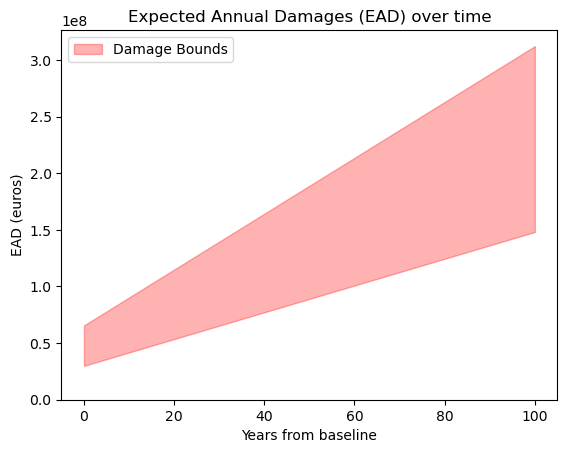

In [10]:
# Define the baseline return periods 
"""
Return period definitions for Rhineland Palatinate (DERP) based on the report by Rauthe M, et al. (2020):
_H_=10-25y 
_M_=100y
_L_=200y
"""
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}

# Add climate change: calculate the dynamic return periods based on flat increase factors. 
# This value has been catchment-specific with frequency increasing in some regions and decreasing in others. 
# It is reasonable that in the future, the frequency will continue to change differently by catchment.

increase_factor = {
    '_H_': 2,
    '_M_': 6.6,
    '_L_': 9.1
} # https://hess.copernicus.org/preprints/hess-2016-65/hess-2016-65-manuscript-version2.pdf 

num_years = 100
return_periods = calculate_dynamic_return_periods(return_period_dict, num_years, increase_factor)

# Define dictionary to relate return periods to regions, in this case Rheinland Palatinate is used
return_period_dict = {}
return_period_dict['DERP'] = return_periods #TODO: make generic for other regions

# Add the return period column to aggregated_df and sort by return period
aggregated_df['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df.index]
aggregated_df = aggregated_df.sort_values('Return Period', ascending=True)

# Calculate the probability of each return period 
aggregated_df['Probability'] = [[1 / x for x in i] for i in aggregated_df['Return Period']]
probabilities = aggregated_df['Probability']
dmgs = []

# Calculate the expected annual damages for each time step using trapezoidal rule for integration
for ts in range(len(probabilities.iloc[0])):    
    dmgs_l = []
    dmgs_u = []

    for rp in range(len(probabilities)-1):
        d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
        trap_damage_l = 0.5 * (aggregated_df['Total Damage Lower Bound'].iloc[rp] + aggregated_df['Total Damage Lower Bound'].iloc[rp + 1])
        trap_damage_u = 0.5 * (aggregated_df['Total Damage Upper Bound'].iloc[rp] + aggregated_df['Total Damage Upper Bound'].iloc[rp + 1])
        dmgs_l.append(d_rp * trap_damage_l)
        dmgs_u.append(d_rp * trap_damage_u)
    
    # Add the portion of damages corresponding to the tails of the distribution
    # Assumption - considers the damage for return periods higher than the highest return period the same as that of the highest return period
    d0_rp = probabilities.iloc[-1][ts]
    damage_l0 = max(aggregated_df['Total Damage Lower Bound'])
    damage_u0 = max(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d0_rp * damage_l0)
    dmgs_u.append(d0_rp * damage_u0)

    # Assumption - considers that no assets are damaged at a return period of 4 years or lower
    d_end_rp = (1/4)-probabilities.iloc[0][ts]
    damage_l_end = 0.5 * min(aggregated_df['Total Damage Lower Bound'])
    damage_u_end = 0.5 * min(aggregated_df['Total Damage Upper Bound'])
    dmgs_l.append(d_end_rp * damage_l_end)
    dmgs_u.append(d_end_rp * damage_u_end)

    dmgs.append((sum(dmgs_l), sum(dmgs_u)))

ead_by_ts = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])

print(f'Baseline expected annual damages: {dmgs[0][0]:,.2f} to {dmgs[0][1]:,.2f} EUR')
print(f'Expected annual damages without adaptation by year {num_years}: {dmgs[-1][0]:,.2f} to {dmgs[-1][1]:,.2f} EUR')

ead_by_ts_plot(ead_by_ts)

In [11]:
# Calculate the expected annual damages (EAD)
summed_output = {}
# Iterate over the items in the collect_output dictionary
for hazard_map, asset_dict in collect_output.items():
    # If the hazard_map and hazard_curve combination is not already in the summed_output dictionary, add it with the sum of the current lower and upper bounds
    if hazard_map not in summed_output:
        summed_output[hazard_map] = (sum(value[0] for value in asset_dict.values()), sum(value[1] for value in asset_dict.values()))
    # If the hazard_map and hazard_curve combination is already in the summed_output dictionary, add the sum of the current lower and upper bounds to the existing ones
    else:
        summed_output[hazard_map][0] += sum(value[0] for value in asset_dict.values())
        summed_output[hazard_map][1] += sum(value[1] for value in asset_dict.values())

summed_output

{'flood_DERP_RW_H_4326_2080410170': (8660.346345429718, 13620.796027616947),
 'flood_DERP_RW_H_4326_2080410430': (37011.78449206103, 158149.38078075842),
 'flood_DERP_RW_H_4326_2080410540': (62528.33745818449, 62528.33745818449),
 'flood_DERP_RW_H_4326_2080410660': (0, 0),
 'flood_DERP_RW_H_4326_2080410760': (0, 0),
 'flood_DERP_RW_H_4326_2080411370': (119700.03477632943, 550561.56526837),
 'flood_DERP_RW_H_4326_2080416200': (0, 0),
 'flood_DERP_RW_H_4326_2080416210': (1469359.531904706, 4351446.776092717),
 'flood_DERP_RW_H_4326_2080418600': (2533662.347499635, 12729388.639742948),
 'flood_DERP_RW_H_4326_2080418720': (0, 0),
 'flood_DERP_RW_H_4326_2080418880': (111629.76363490838, 112759.18055462776),
 'flood_DERP_RW_H_4326_2080418890': (0, 0),
 'flood_DERP_RW_H_4326_2080419070': (0, 0),
 'flood_DERP_RW_H_4326_2080419180': (1444607.1537085557, 4762138.50663099),
 'flood_DERP_RW_H_4326_2080420240': (123217.36975193478, 339459.01950973005),
 'flood_DERP_RW_H_4326_2080420340': (0, 0),
 '

In [12]:
files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list=list(set([int(file.split('.')[0].split('_')[-1]) for file in files]))
# summed_output  is a dicitonary of with keys as the hazard map names and values as a tuple of the lower and upper bounds of the total damage
# example: {'flood_DERP_RW_H_4326_2080411370': (3706407.631635442, 13355041.119988918),

# for a list of all the basins in the region, retrieve the upper and lower damage bounds for each basin and skip if the basin is not a key in the summed_output dictionary

# create a dictionary of dictionaries with the basin number as the level 1 key, the category (ie "H") as the level 2 key and the upper and lower bounds as the values
basin_dict = {}
for basin in basins_list:
    basin_dict[basin] = {}
    for key in summed_output.keys():
        if str(basin) in key:
            basin_dict[basin][key.split('_RW')[-1][0:3]] = summed_output[key]


aggregated_df_by_basin = {}
ead_by_ts_by_basin = {}

for basin, damage_dict in basin_dict.items():
    if len(damage_dict) == 0:
        continue
    aggregated_df_by_basin[basin] = pd.DataFrame.from_dict(damage_dict, orient='index', columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    aggregated_df_by_basin[basin]['Return Period'] = [return_period_dict['DERP'][index] for index in aggregated_df_by_basin[basin].index]
    aggregated_df_by_basin[basin] = aggregated_df_by_basin[basin].sort_values('Return Period', ascending=True)
    aggregated_df_by_basin[basin]['Probability'] = [[1 / x for x in i] for i in aggregated_df_by_basin[basin]['Return Period']]
    probabilities = aggregated_df_by_basin[basin]['Probability']
    dmgs = []

    for ts in range(len(probabilities.iloc[0])):    
        dmgs_l = []
        dmgs_u = []

        for rp in range(len(probabilities)-1):
            d_rp= probabilities.iloc[rp][ts] - probabilities.iloc[rp + 1][ts]
            trap_damage_l = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Lower Bound'].iloc[rp + 1])
            trap_damage_u = 0.5 * (aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp] + aggregated_df_by_basin[basin]['Total Damage Upper Bound'].iloc[rp + 1])
            dmgs_l.append(d_rp * trap_damage_l)
            dmgs_u.append(d_rp * trap_damage_u)
        
        # Add the portion of damages corresponding to the tails of the distribution
        d0_rp = probabilities.iloc[-1][ts]
        damage_l0 = max(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u0 = max(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d0_rp * damage_l0)
        dmgs_u.append(d0_rp * damage_u0)

        d_end_rp = (1/4)-probabilities.iloc[0][ts]
        damage_l_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Lower Bound'])
        damage_u_end = 0.5 * min(aggregated_df_by_basin[basin]['Total Damage Upper Bound'])
        dmgs_l.append(d_end_rp * damage_l_end)
        dmgs_u.append(d_end_rp * damage_u_end)

        dmgs.append((sum(dmgs_l), sum(dmgs_u)))
    
    ead_by_ts_by_basin[basin] = pd.DataFrame(dmgs, columns=['Total Damage Lower Bound', 'Total Damage Upper Bound'])
    
 


In [13]:
total_damage_lower_bound = ead_by_ts_by_basin[basins_list[0]]['Total Damage Lower Bound']
print(f'Baseline expected annual damages for basin {basins_list[0]}:{sum(total_damage_lower_bound):,.2f} EUR')
total_damage_upper_bound = ead_by_ts_by_basin[basins_list[0]]['Total Damage Upper Bound']
print(f'Baseline expected annual damages for basin {basins_list[0]}:{sum(total_damage_upper_bound):,.2f} EUR')


Baseline expected annual damages for basin 2080428160:293,783,372.13 EUR
Baseline expected annual damages for basin 2080428160:427,619,247.25 EUR


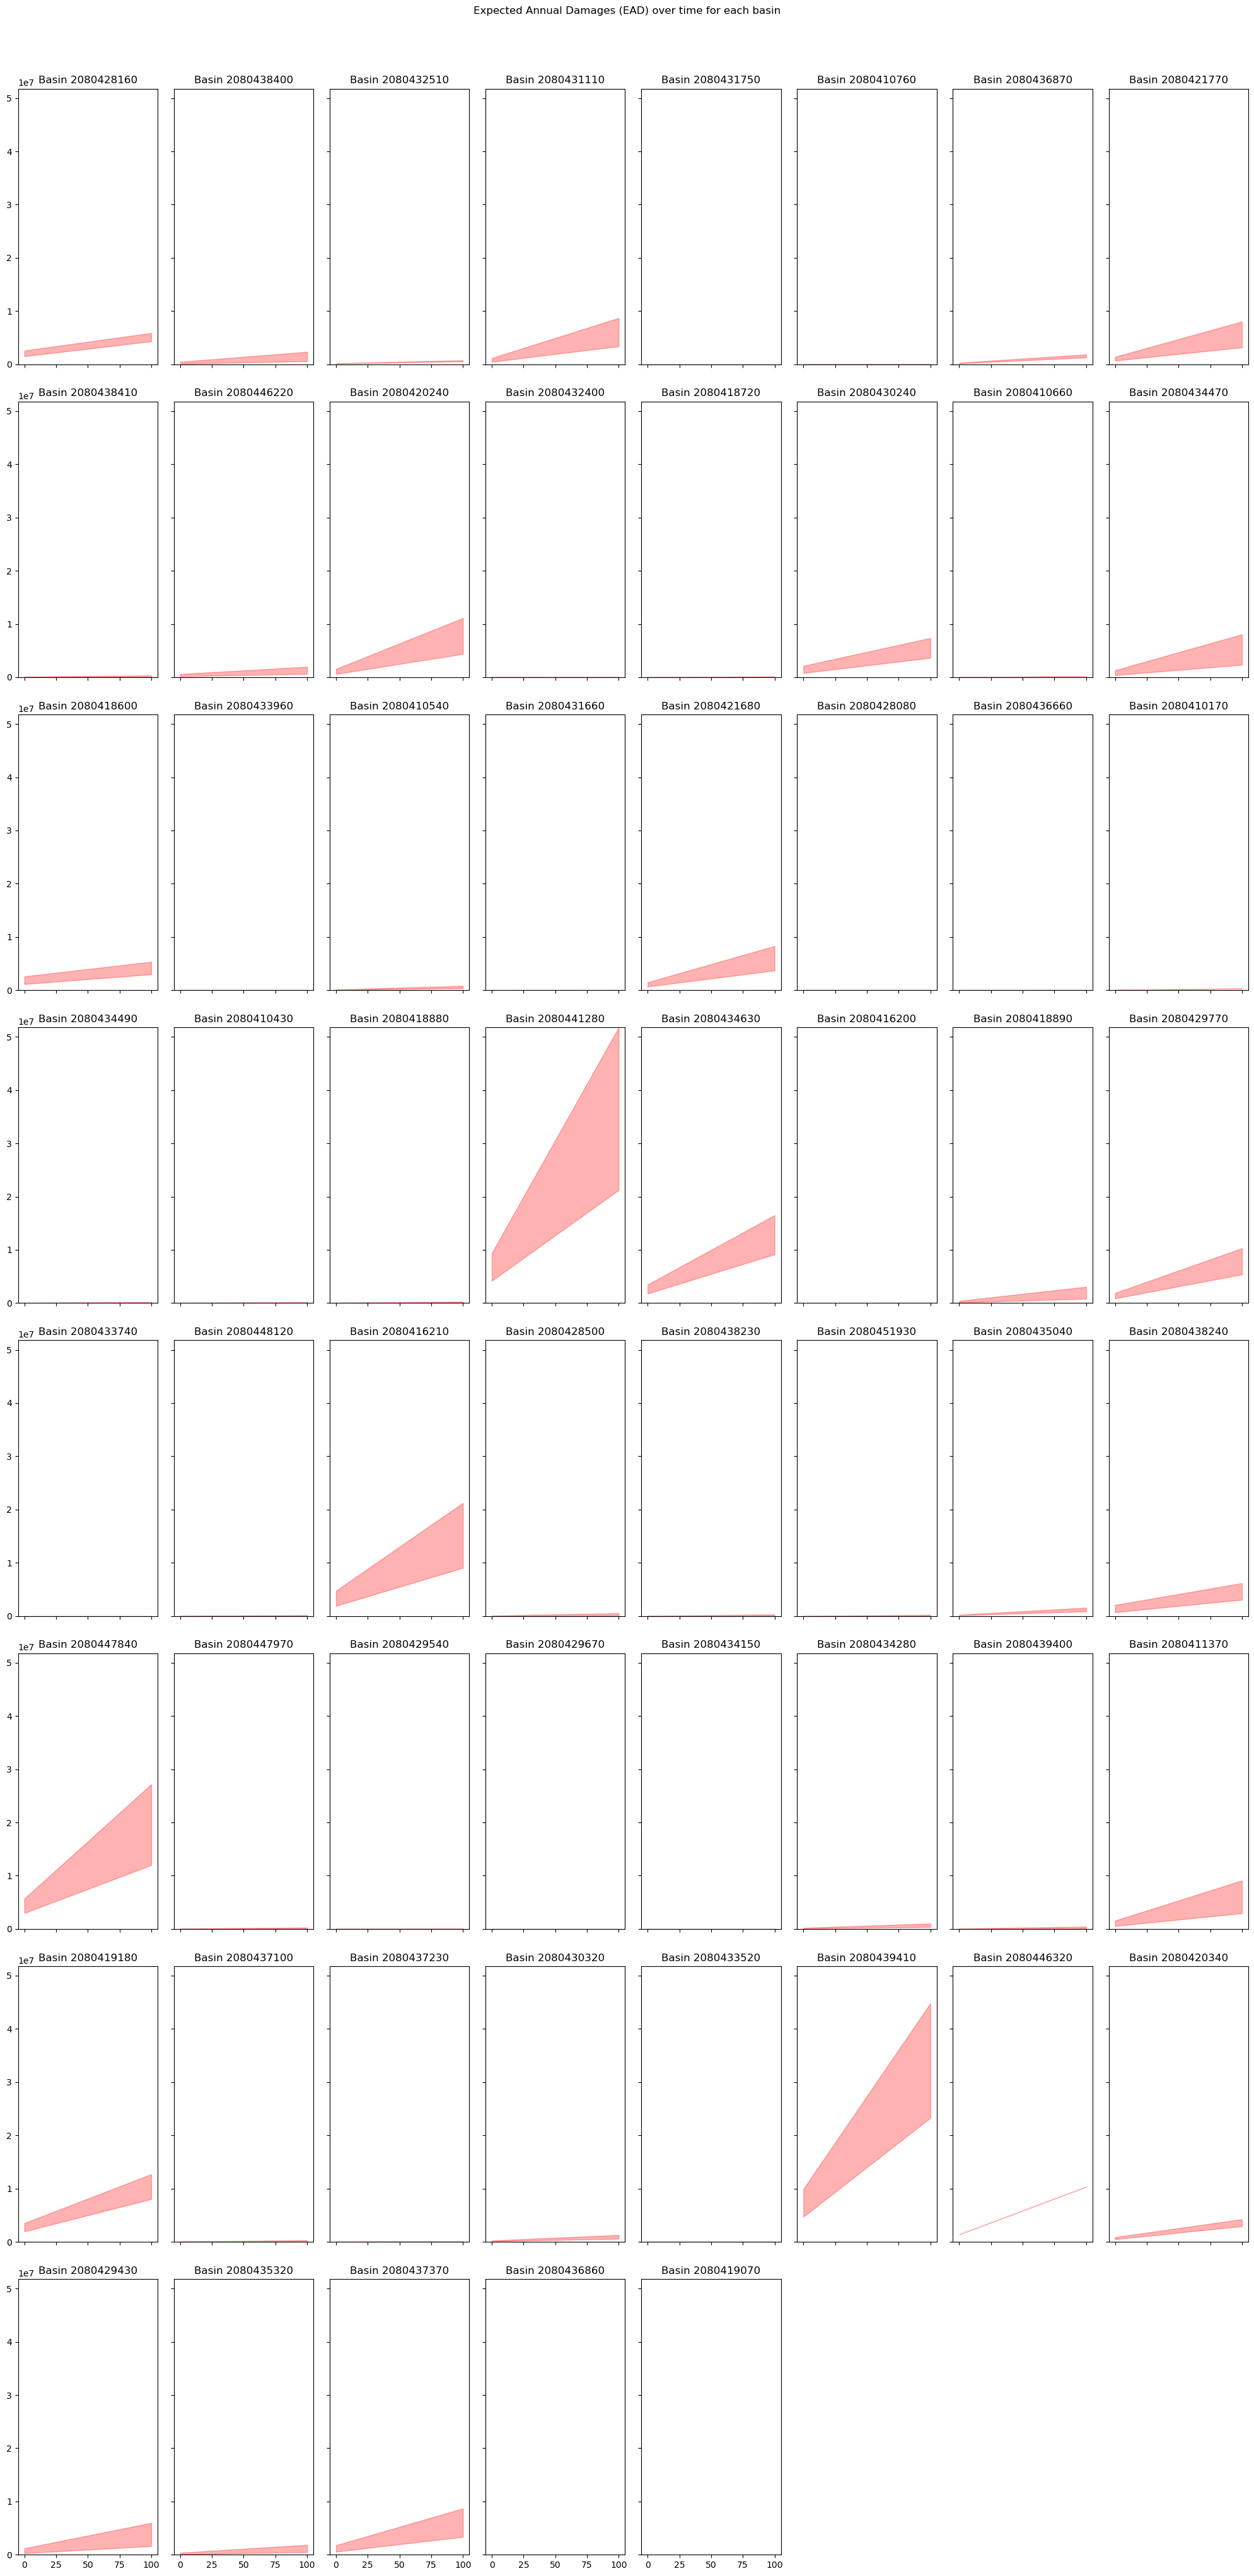

In [14]:
# Calculate the number of rows and columns based on the number of basins
num_basins = len(ead_by_ts_by_basin)
num_cols = int(np.ceil(np.sqrt(num_basins)))
num_rows = int(np.ceil(num_basins / num_cols))

# Create subplots with shared x-axis, the calculated number of rows and columns
fig, axs = plt.subplots(num_rows, num_cols, figsize=(20, 5*num_rows), sharex=True, sharey=True)

# Flatten axs array for easy iteration
axs = axs.flatten()

max_value = max([ead_by_ts_by_basin[basin]['Total Damage Upper Bound'].max() for basin in ead_by_ts_by_basin.keys()])

for i, basin in enumerate(ead_by_ts_by_basin.keys()):
    axs[i].fill_between(ead_by_ts_by_basin[basin].index, ead_by_ts_by_basin[basin]['Total Damage Lower Bound'], ead_by_ts_by_basin[basin]['Total Damage Upper Bound'], alpha=0.3, color='red')
    axs[i].set_title(f'Basin {basin}')
    axs[i].set_ylim(0, max_value)  # Set y-axis lower limit to 0 and upper limit to max_value

# Hide any unused axes
for j in range(num_basins, num_rows * num_cols):
    axs[j].axis('off')

plt.tight_layout()
plt.suptitle('Expected Annual Damages (EAD) over time for each basin', y=1.02)
plt.show()


In [15]:
with open(f'{interim_data_path}/ead_by_ts_by_basin_direct.pkl', 'wb') as f:
    pickle.dump(ead_by_ts_by_basin, f)

In [16]:
ead_by_ts_by_basin

{2080428160:      Total Damage Lower Bound  Total Damage Upper Bound
 0                1.502038e+06              2.582543e+06
 1                1.530172e+06              2.615569e+06
 2                1.558306e+06              2.648595e+06
 3                1.586440e+06              2.681621e+06
 4                1.614575e+06              2.714648e+06
 ..                        ...                       ...
 96               4.202918e+06              5.753060e+06
 97               4.231052e+06              5.786087e+06
 98               4.259186e+06              5.819113e+06
 99               4.287320e+06              5.852139e+06
 100              4.315455e+06              5.885165e+06
 
 [101 rows x 2 columns],
 2080438400:      Total Damage Lower Bound  Total Damage Upper Bound
 0                82485.574449              4.633800e+05
 1                87464.114030              4.821675e+05
 2                92442.653611              5.009551e+05
 3                97421.193192       